# ML Zoomcamp 2023 - Homework #9

Name: Wong Chee Fah

Email: wongcheefah@gmail.com

In this homework, we'll deploy the bees vs wasps model we trained in the 
[previous homework](../08-deep-learning/homework.md).

Download the model from here: 

https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5

In [110]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow.lite as tflite

from io import BytesIO
from urllib import request

from PIL import Image

## Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the **converted** model?

* 21 Mb
* 43 Mb
* 80 Mb
* 164 Mb

In [111]:

model = keras.models.load_model('bees-wasps.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('bees-wasps.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpu2owv8q3/assets


INFO:tensorflow:Assets written to: /tmp/tmpu2owv8q3/assets
2023-11-30 01:26:40.453759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-30 01:26:40.455776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-30 01:26:40.468686: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpu2owv8q3
2023-11-30 01:26:40.469448: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-30 01:26:40.469462: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpu2owv8q3
2023-11-30 01:26:40.514318: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-30 01:26:40.734551: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpu2owv8q3
2023-11-30 01:26:40.744323: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [112]:
!ls -l --block-size=M bees-wasps.tflite

-rw-r--r-- 1 wongcheefah wongcheefah 43M Nov 30 01:26 bees-wasps.tflite


##### Ans: `43 MB`

## Question 2

To be able to use this model, we need to know the index of the input and 
the index of the output. 

What's the output index for this model?

* 3
* 7
* 13
* 24

In [113]:
interpreter = tflite.Interpreter(model_path='bees-wasps.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [114]:
output_index

13

##### Ans: `13`

## Preparing the image

Let's download and resize this image: 

https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

Based on the previous homework, what should be the target size for the image?

## Question 3

Now we need to turn the image into numpy array and pre-process it. 

> Tip: Check the previous homework. What was the pre-processing 
> we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

* 0.3450980
* 0.5450980
* 0.7450980
* 0.9450980


In [115]:
def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

# Pre-processing in homework 8 was rescaling by dividing by 255
def preprocess_input(x):
    x /= 255.
    return x

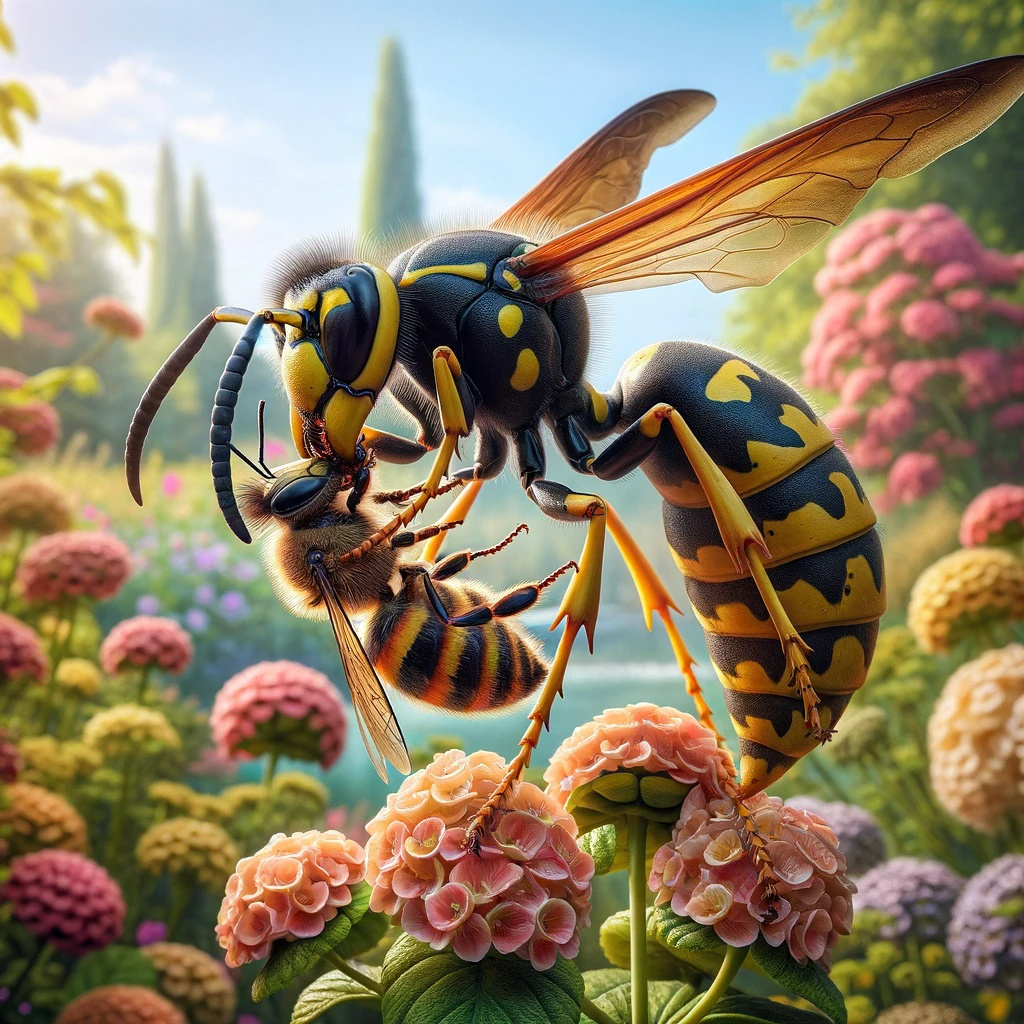

In [116]:
url = 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'

img = download_image(url)
img

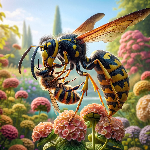

In [117]:
target_size = (150, 150)

img = prepare_image(img, target_size)
img

In [118]:
x = np.array(img, dtype='float32')
X = np.array([x])

X = preprocess_input(X)

In [119]:
X.shape

(1, 150, 150, 3)

In [120]:
X[0, 0, 0, 0]

0.94509804

##### Ans: `0.9450980`

## Question 4

Now let's apply this model to this image. What's the output of the model?

* 0.258
* 0.458
* 0.658
* 0.858

In [121]:
def predict(url):
    img = prepare_image(download_image(url), target_size)
    
    x = np.array(img, dtype='float32')
    X = np.array([x])
    X = preprocess_input(X)
    
    interpreter.set_tensor(input_index, X)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_index)

    float_prediction = float(preds[0, 0])
    
    return float_prediction

In [122]:
predict(url)

0.6589840650558472

##### Ans: `0.658`

## Prepare the lambda code 

Copy all the code into a separate python file to use this file for the next two questions.

## Docker 

For the next two questions, we'll use a Docker image that we already prepared. This is the Dockerfile that we used for creating the image:

```docker
FROM public.ecr.aws/lambda/python:3.10
COPY bees-wasps-v2.tflite .
```

And pushed it to [`agrigorev/zoomcamp-bees-wasps:v2`](https://hub.docker.com/r/agrigorev/zoomcamp-bees-wasps/tags).

A few notes:

* The image already contains a model and it's not the same model
  as the one we used for questions 1-4.
* The version of Python is 3.10, so you need to use the right wheel for 
  TF-Lite. For Tensorflow 2.14.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.14.0-cp310-cp310-linux_x86_64.whl

## Question 5

Download the base image `agrigorev/zoomcamp-bees-wasps:v2` by using the [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.

So what's the size of this base image?

* 162 Mb
* 362 Mb
* 662 Mb
* 962 Mb

In [91]:
!docker pull agrigorev/zoomcamp-bees-wasps:v2

v2: Pulling from agrigorev/zoomcamp-bees-wasps

68a79b8a: Pulling fs layer 
124cce46: Pulling fs layer 
8b038848: Pulling fs layer 
7e7c1be9: Pulling fs layer 
8c0b7487: Pulling fs layer 
0580071d: Pulling fs layer 
Digest: sha256:823f8536a45968f40ee3daf8a2da030b914912a382a4611610b3b84d36d2924c[7ADownloading  8.103MB/12.09MBDownloading  3.712MB/40.75MB
Status: Downloaded newer image for agrigorev/zoomcamp-bees-wasps:v2
docker.io/agrigorev/zoomcamp-bees-wasps:v2

What's Next?
  View a summary of image vulnerabilities and recommendations → docker scout quickview agrigorev/zoomcamp-bees-wasps:v2


In [92]:
!docker images

REPOSITORY                        TAG       IMAGE ID       CREATED       SIZE
agrigorev/zoomcamp-bees-wasps     v2        b9f6c13de368   11 days ago   662MB
mikesir87/dockercon23-extension   latest    0199f01f5b7f   8 weeks ago   219MB


##### Ans: `662 MB`

## Question 6

Let's extend this docker image, install all the required libraries
and add the code for lambda.

There's no need to include the model in the image. It's already included. 
The name of the file with the model is `bees-wasps-v2.tflite` and it's 
in the current workdir in the image (see the Dockerfile above for the 
reference). 
The provided model requires the same preprocessing for images regarding target size and rescaling the value range then used in homework 8.

Run the container locally.

Score this image: https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

What's the output from the model?

* 0.2453
* 0.4453
* 0.6453
* 0.8453

In [123]:
!python3 test.py

0.4453350603580475


##### Ans: `0.4453`